<a href="https://colab.research.google.com/github/veniceofcode/chbox/blob/main/UniverSeg_tutorial_and_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UniverSeg: Universal Medical Image Segmentation

This colab notebook is tutorial and demonstration of various aspects of [UniverSeg](https://universeg.csail.mit.edu/).

For demonstration, we employ two datasets, [WBC](https://github.com/zxaoyou/segmentation_WBC) and [OASIS](https://github.com/adalca/medical-datasets/blob/master/neurite-oasis.md)

For more information about UniverSeg please visit the website.

> For GPU acceleration go to Edit > Notebook Settings  and for Hardware Accelerator select GPU




## 1. Setup

First, we clone the UniverSeg repo and install necessary dependencies

In [ ]:
!git clone https://github.com/JJGO/UniverSeg
!python -m pip install -r ./UniverSeg/requirements.txt

fatal: destination path 'UniverSeg' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import math
import itertools

from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

import einops as E

Prepare `universeg`: import, setup GPU, and load model

In [ ]:
import sys
sys.path.append('UniverSeg')

import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

from universeg import universeg
model = universeg(pretrained=True)
_ = model.to(device)

Prepare a quick helpful function for visualizing data for this tutorial

In [ ]:
def visualize_tensors(tensors, col_wrap=8, col_names=None, title=None):
    M = len(tensors)
    N = len(next(iter(tensors.values())))

    cols = col_wrap
    rows = math.ceil(N/cols) * M

    d = 2.5
    fig, axes = plt.subplots(rows, cols, figsize=(d*cols, d*rows))
    if rows == 1:
      axes = axes.reshape(1, cols)

    for g, (grp, tensors) in enumerate(tensors.items()):
        for k, tensor in enumerate(tensors):
            col = k % cols
            row = g + M*(k//cols)
            x = tensor.detach().cpu().numpy().squeeze()
            ax = axes[row,col]
            if len(x.shape) == 2:
                ax.imshow(x,vmin=0, vmax=1, cmap='gray')
            else:
                ax.imshow(E.rearrange(x,'C H W -> H W C'))
            if col == 0:
                ax.set_ylabel(grp, fontsize=16)
            if col_names is not None and row == 0:
                ax.set_title(col_names[col])

    for i in range(rows):
        for j in range(cols):
            ax = axes[i,j]
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])

    if title:
        plt.suptitle(title, fontsize=20)

    plt.tight_layout()

---



## 2. Inference on unseen segmentation task

In this section we will show how a global universeg can segment images from a new segmentation task -- in a completely unseen domain


Given a new segmentation task (e.g. new biomedical domain, new image type, new region of interest, etc), most existing strategies involve training or fine-tuning a segmentation model (often a UNet-like CNN) that takes as input an image $x$ and outputs the segmentation map $y$.

This process works well in machine-learning labs, but is challenging in many applied settings, such as for scientists or clinical researchers who drive important scientific questions, but often lack the machine-learning expertiese and computational resources necessary.

UniverSeg enables users to tackle a new segmentation task without the need to train or fine-tune a model, removing the ML experience requirements and computational burden. The key idea is to have a *single* global model which adapts to a new segmentation task at inference. Given a new segmentation task, defined by a few example image-segmentation pairs $\mathcal{T} = \{x_n, y_n\}$, UniverSeg segments a new image $x$ by taking as input both $x$ and the task examples $\mathcal{T}$ and outputs the segmentation map $f(x, \mathcal{T}) = y$.

#### White Blood Cell Segmentation
We will demonstrate this concept with the task of segmenting [white blood cells (WBC)](https://github.com/zxaoyou/segmentation_WBC).

The global UniverSeg model was trained on a variety of tasks, but did not include this segmentation task (or any other very similar task).

Let's load the data

In [ ]:
from example_data.wbc import WBCDataset

d_support = WBCDataset('JTSC', split='support', label='cytoplasm')
d_test = WBCDataset('JTSC', split='test', label='cytoplasm')

n_support = 48

support_images, support_labels = zip(*itertools.islice(d_support, n_support))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)

Let's visualize some examples we are going to use as the example set $\{x_n, y_n\}$ (referred to as **support** set)

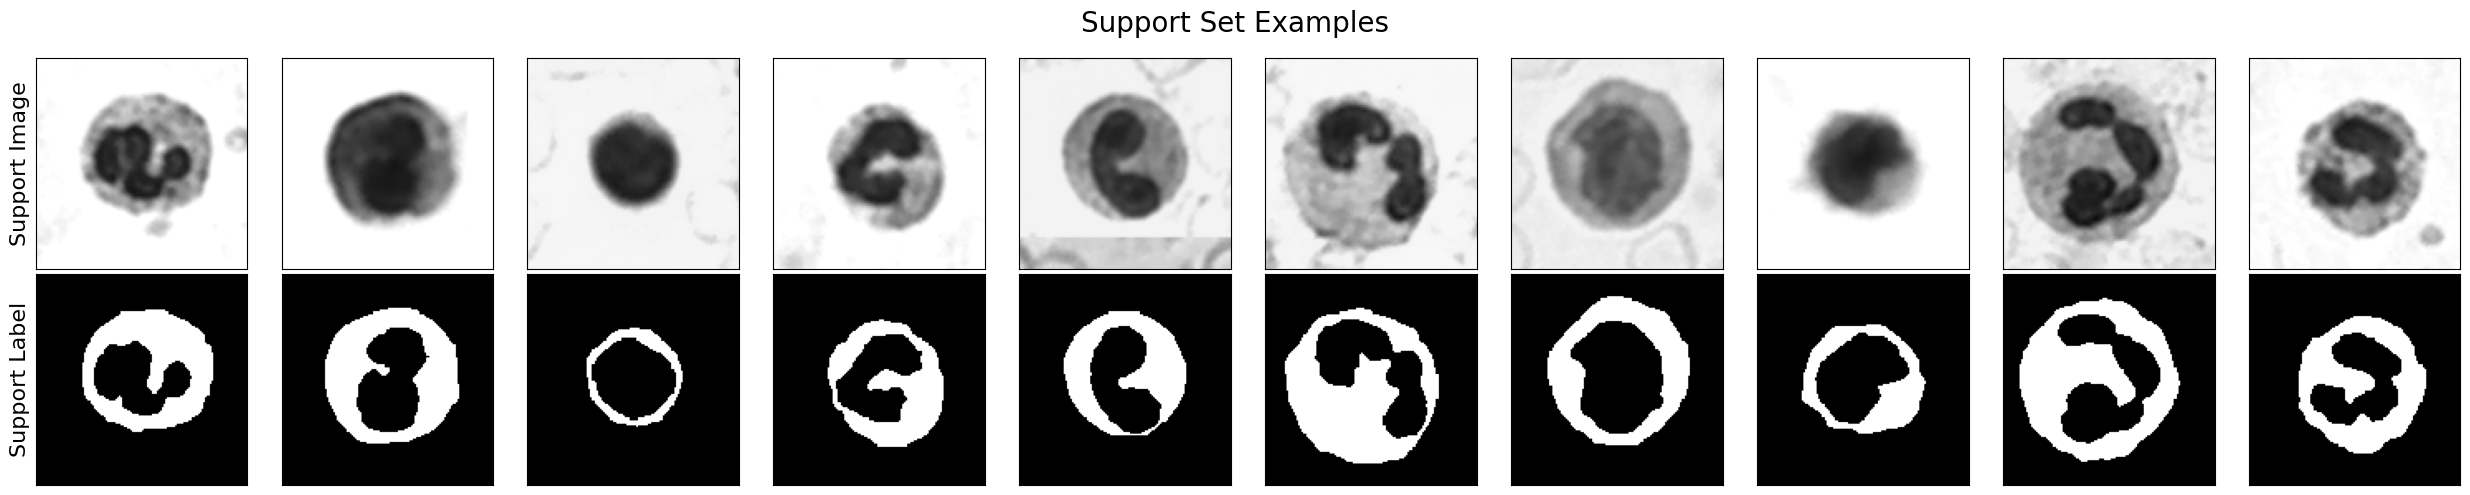

In [ ]:
n_viz = 10
visualize_tensors({
    'Support Image': support_images[:n_viz],
    'Support Label': support_labels[:n_viz],
}, col_wrap=10, title='Support Set Examples')

Let's perform inference on a test entry and visualize the prediction

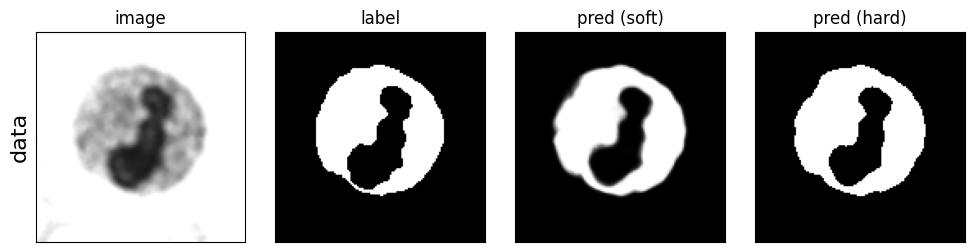

In [ ]:
# select an image, label test pair
idx = np.random.permutation(len(d_test))[0]
image, label = d_test[idx]
image, label = image.to(device), label.to(device)

# run inference
logits = model(image[None], support_images[None], support_labels[None])[0].to('cpu')
pred = torch.sigmoid(logits)

# visualize
res = {'data': [image, label, pred, pred > 0.5]}
titles = col_names=['image', 'label', 'pred (soft)', 'pred (hard)']
visualize_tensors(res, col_wrap=4, col_names=titles)

In most instances, we can see visually great results, despite never having seen this task or domain in training!  
The network essentially learns to look at the example (support) set and copy over to the image data.

-----------------

## 3. Inference Analysis

Next, we run inference for many images, compute metrics, and visualize.  
These will form the foundation for more analysis we do below into how the robustness of UniverSeg and how its performance is affected by the support set choice.


In [ ]:
# Dice metric for measuring volume agreement
def dice_score(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    y_pred = y_pred.long()
    y_true = y_true.long()
    score = 2*(y_pred*y_true).sum() / (y_pred.sum() + y_true.sum())
    return score.item()

In [ ]:
# run inference and compute losses for one test image
@torch.no_grad()
def inference(model, image, label, support_images, support_labels):
    image, label = image.to(device), label.to(device)

    # inference
    logits = model(
        image[None],
        support_images[None],
        support_labels[None]
    )[0] # outputs are logits

    soft_pred = torch.sigmoid(logits)
    hard_pred = soft_pred.round().clip(0,1)

    #  score
    score = dice_score(hard_pred, label)

    # return a dictionary of all relevant variables
    return {'Image': image,
            'Soft Prediction': soft_pred,
            'Prediction': hard_pred,
            'Ground Truth': label,
            'score': score}

  0%|          | 0/10 [00:00<?, ?it/s]

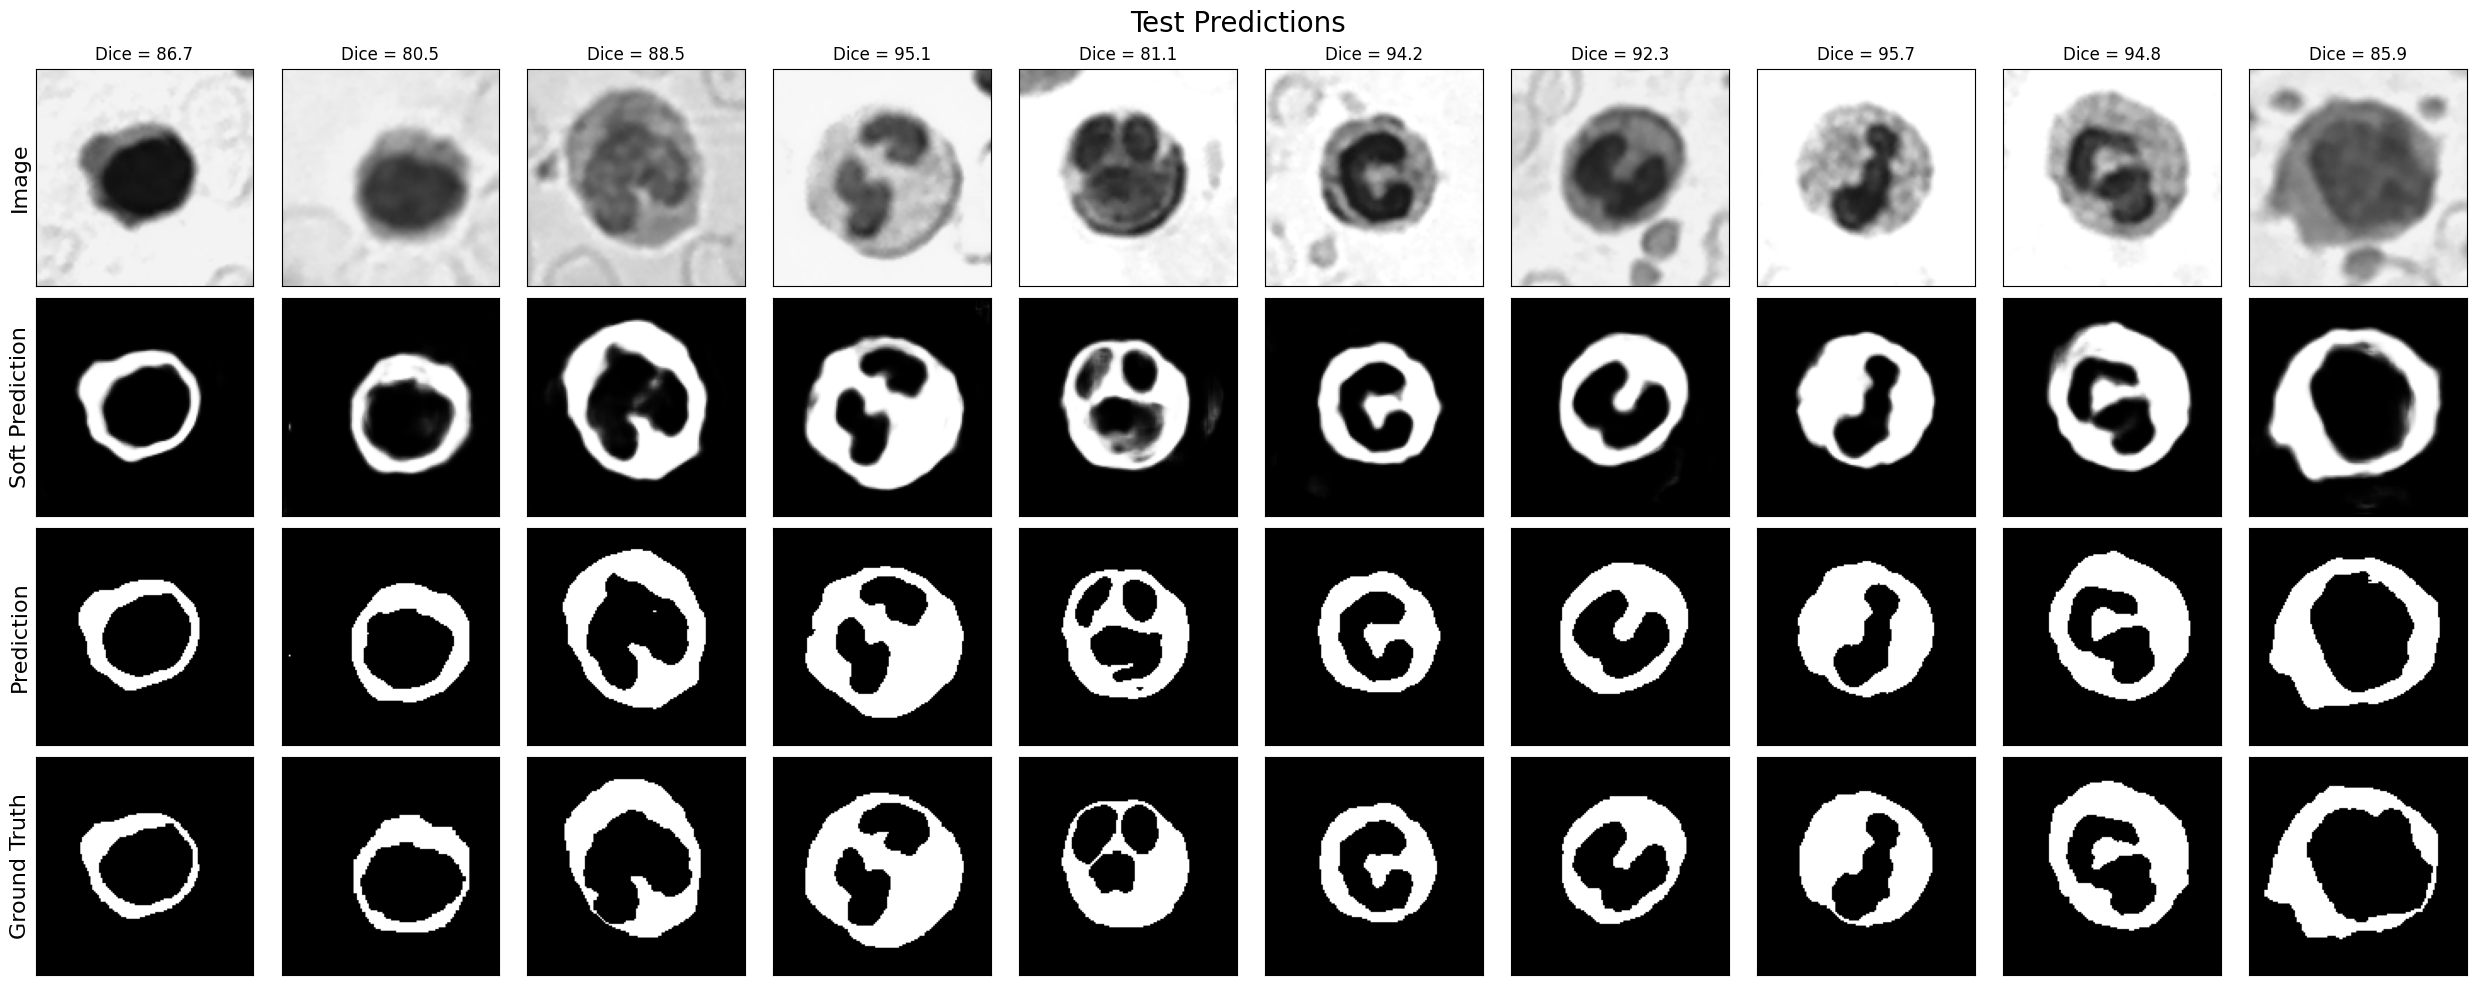

In [ ]:
from collections import defaultdict

n_predictions = 10

results = defaultdict(list)

# compute inference and save predictions and metrics for n_predictions
idxs = np.random.permutation(len(d_test))[:n_predictions]

for i in tqdm(idxs):
    image, label = d_test[i]
    vals = inference(model, image, label, support_images, support_labels)
    for k, v in vals.items():
        results[k].append(v)

# visualize the results, along with their scores
scores = results.pop('score')
visualize_tensors(results,
                  col_names=[f'Dice = {100*s:.1f}' for s in scores],
                  title='Test Predictions',
                  col_wrap=n_predictions)

As before, we can see that both visually and numerically (via Dice) UniverSeg performs well on WBC data despite never having seen it during training.

Next, we analyze how these results will change depending on the example set -- which would be the data a user has available for their work.

---

## 4. Flexibility

We analyze how UniverSeg behaves when we run inference for a different label, or images that undergo a transformation. Specifically, we show the effects of:

4.1. Changing the support labels changes the segmentation task  
4.2. Transforming the images leads to the similar predictions  

### 4.1. Change support labels

Above, we showed results on the **cytoplasm** label in WBC.  
Here, we will show how we can easily get segmentations for another label (**nucleus**) in the same data by simply changing the support label images.

In [ ]:
n_support = 64

In [ ]:
# extract nucleus support data
d_support = WBCDataset('JTSC', split='support', label='nucleus')
d_test = WBCDataset('JTSC', split='test', label='nucleus')

support_images, support_labels = zip(*itertools.islice(d_support, n_support))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)

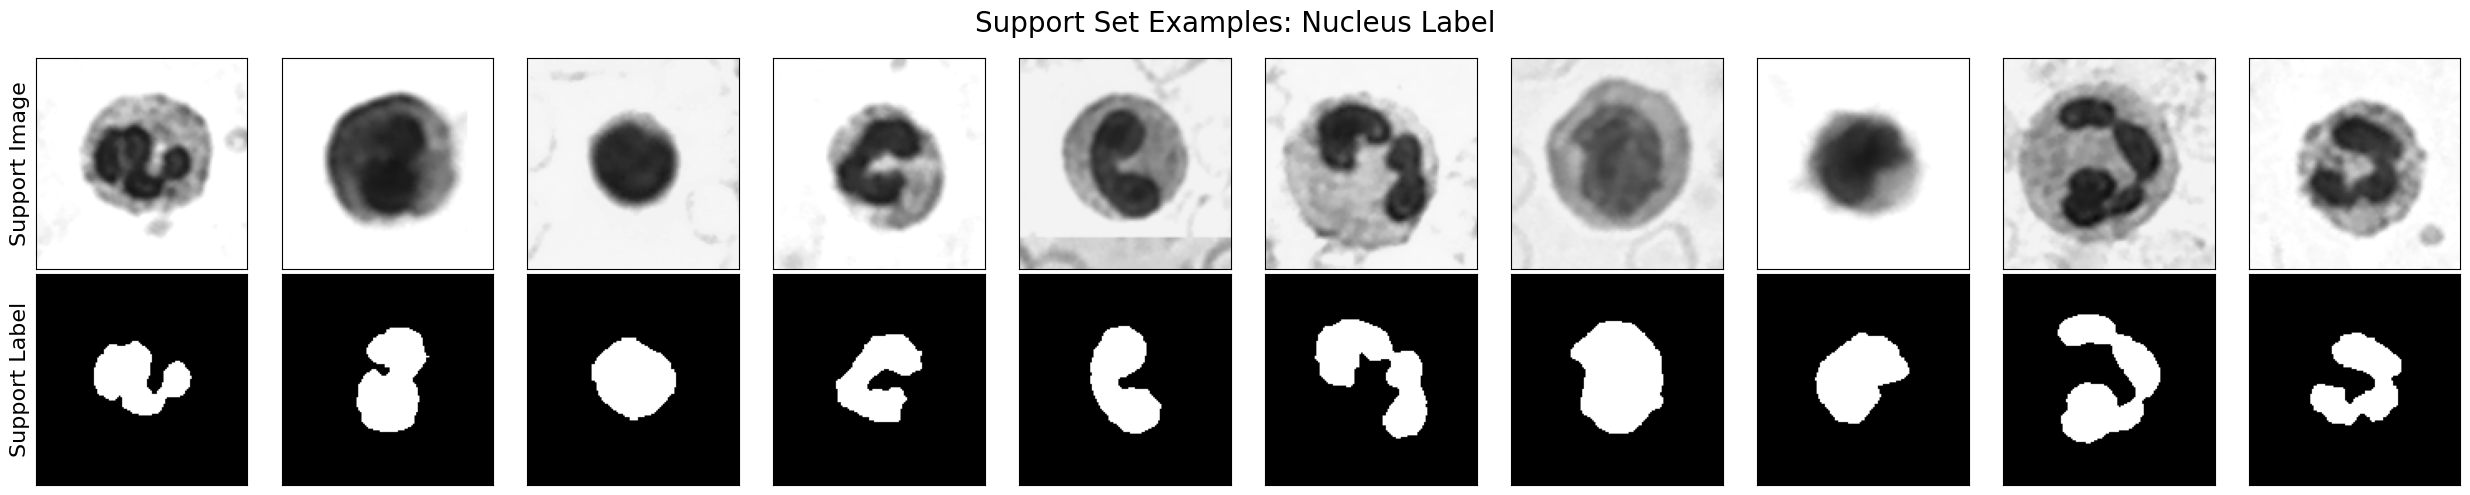

In [ ]:
# visualize nucleus support data
n_viz = 10
visualize_tensors({
    'Support Image': support_images[:n_viz],
    'Support Label': support_labels[:n_viz],
}, col_wrap=10, title='Support Set Examples: Nucleus Label')

compute 10 **nucleus** predictions and visualize

  0%|          | 0/10 [00:00<?, ?it/s]

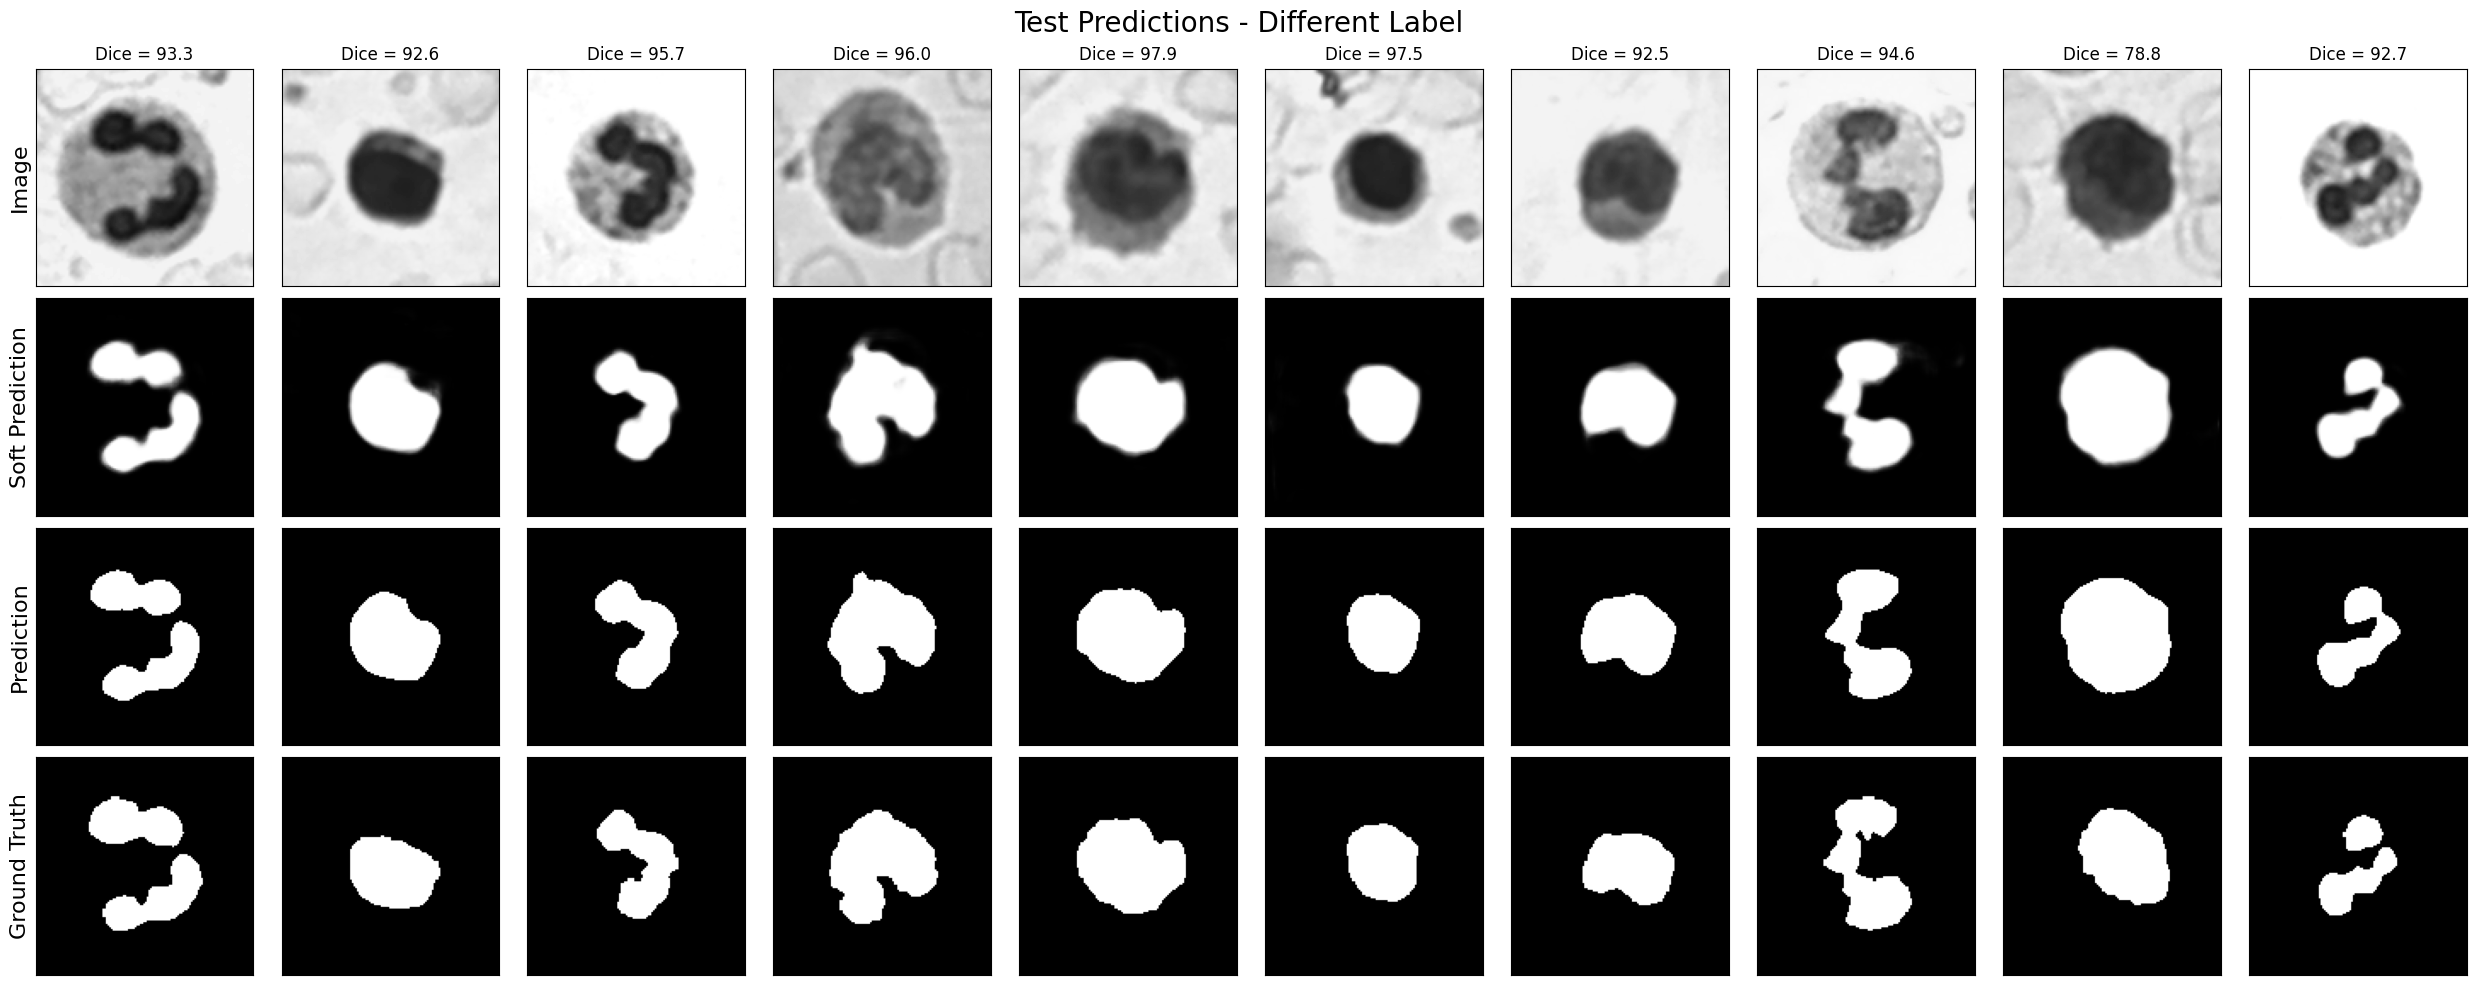

In [ ]:
n_predictions = 10

results = defaultdict(list)

idxs = np.random.permutation(len(d_test))[:n_predictions]
for i in tqdm(idxs):
    image, label = d_test[i]
    vals = inference(model, image, label, support_images, support_labels)
    for k, v in vals.items():
        results[k].append(v)

scores = results.pop('score')
visualize_tensors(results, col_names=[f'Dice = {100*s:.1f}' for s in scores], title='Test Predictions - Different Label', col_wrap=n_predictions)

So by quickly changing the support data we can segment a new label in those same images, again with pretty good accuracy.

### 4.2 Changing input images

In this experiment, we invert the input images and segment the cytoplasm (as in section 2 and 3) to show that we continue to get good results.

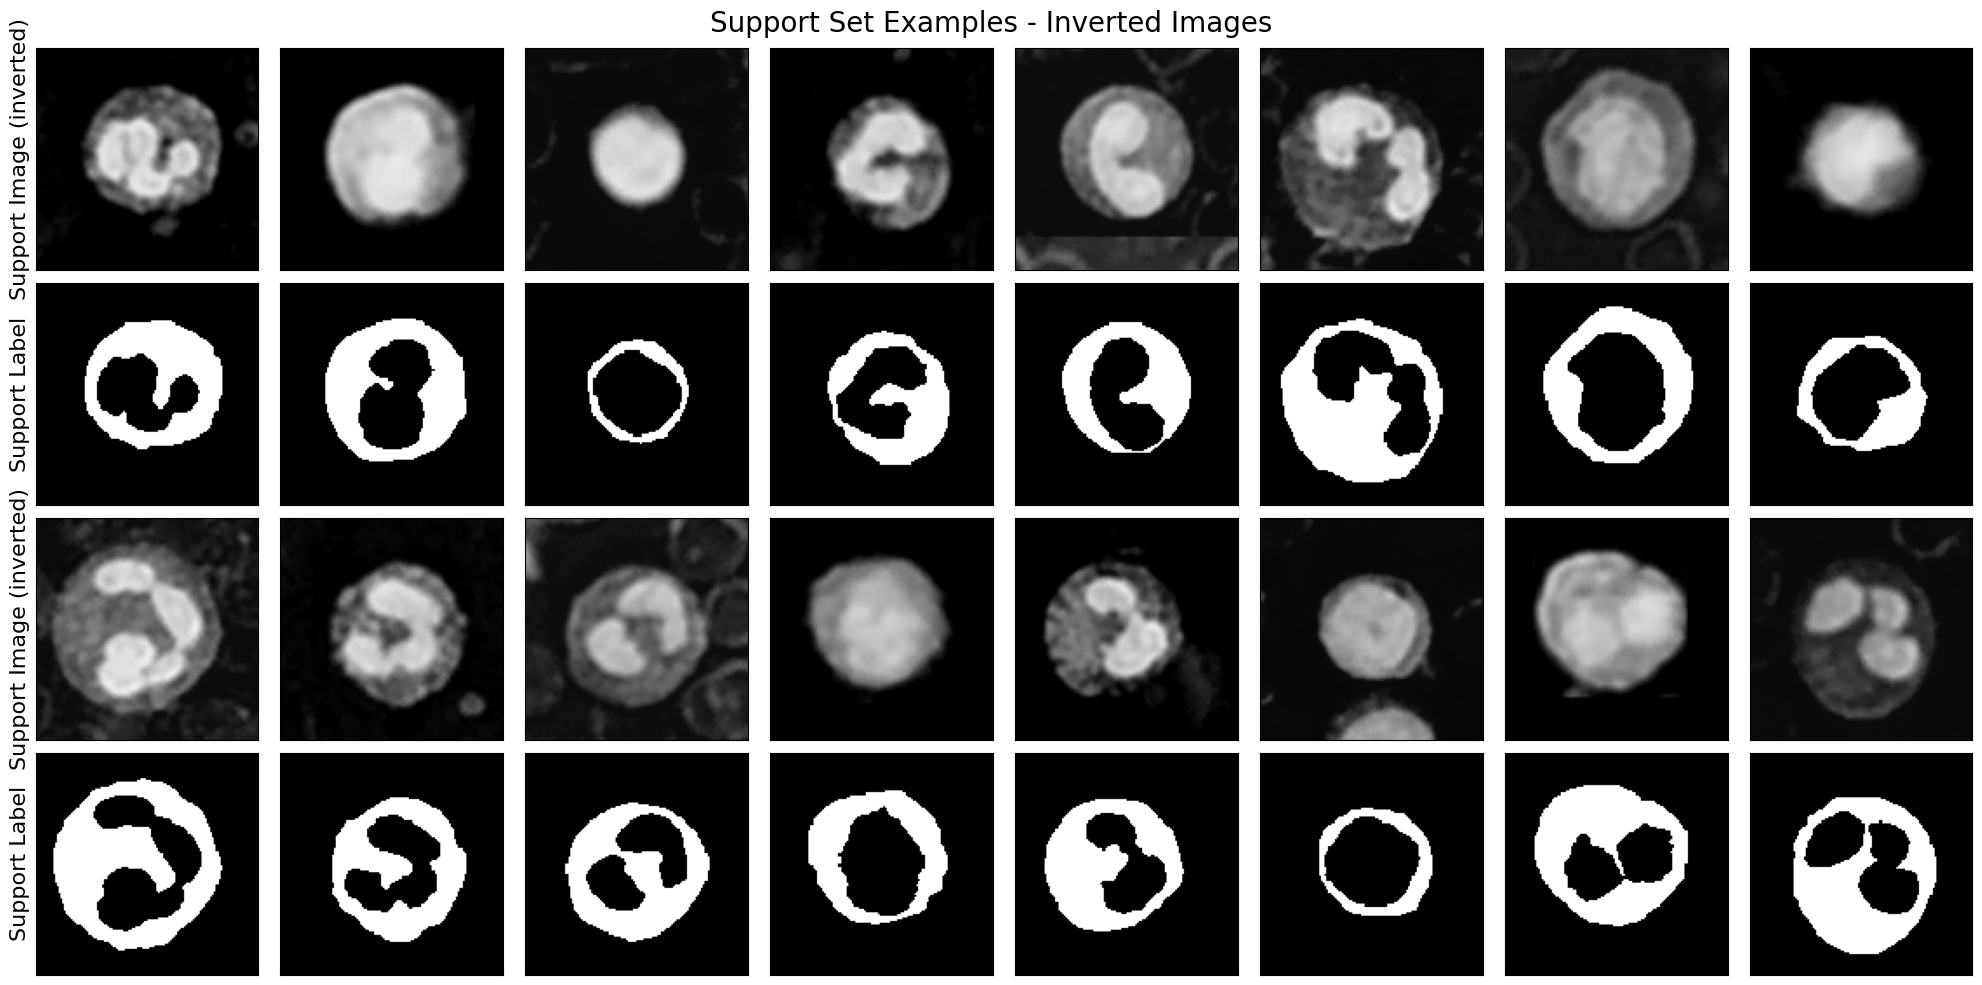

In [ ]:
# extract cytoplasm support set
d_support = WBCDataset('JTSC', split='support', label='cytoplasm')
d_test = WBCDataset('JTSC', split='test', label='cytoplasm')

n_support = 64

support_images, support_labels = zip(*itertools.islice(d_support, n_support))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)

# invert images by intensity
support_images = 1 - support_images

# visualize support set
n_viz = 16
visualize_tensors({
    'Support Image (inverted)': support_images[:n_viz],
    'Support Label': support_labels[:n_viz],
}, 8,  title='Support Set Examples - Inverted Images')

  0%|          | 0/10 [00:00<?, ?it/s]

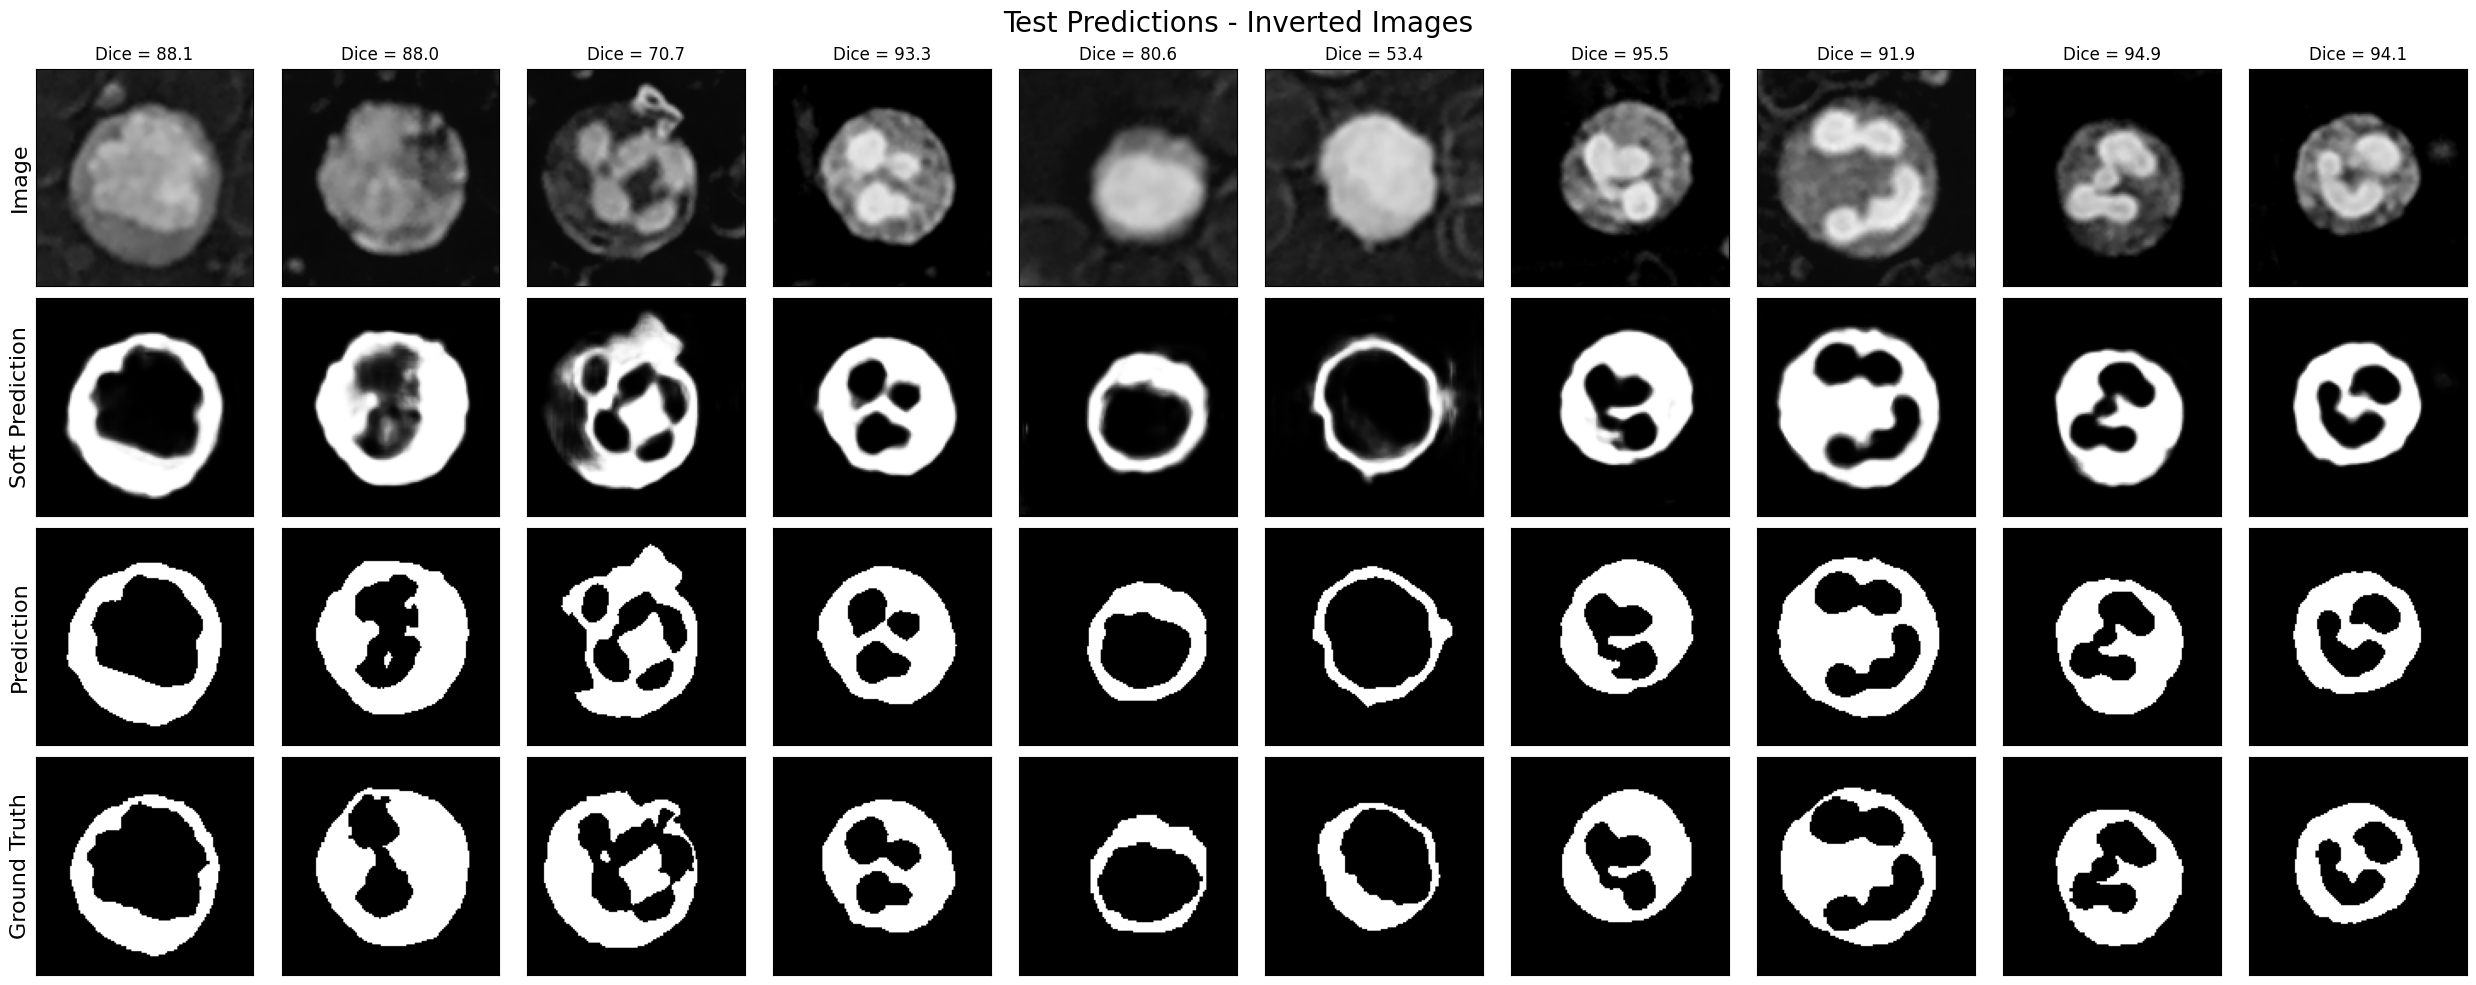

In [ ]:
# run inference on inverted images (both the query image of interest, and support data)
n_predictions = 10

results = defaultdict(list)
idxs = np.random.permutation(len(d_test))[:n_predictions]

for i in tqdm(idxs):
    image, label = d_test[i]
    vals = inference(model, 1-image, label, support_images, support_labels)
    for k, v in vals.items():
        results[k].append(v)

scores = results.pop('score')
visualize_tensors(results, col_names=[f'Dice = {100*s:.1f}' for s in scores], title='Test Predictions - Inverted Images', col_wrap=n_predictions)

------------------------------------------


## 5. Effect of the Support Set Size

Here we study how changing the number of support examples affects the prediction, and find that increasing the support set size leads to improved results

Again, we start by getting some support data

In [ ]:
d_support = WBCDataset('JTSC', split='support', label='cytoplasm')
d_test = WBCDataset('JTSC', split='test', label='cytoplasm')

n_support = 64

support_images, support_labels = zip(*itertools.islice(d_support, n_support))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)

make 3 predictions, for each of different support set sizes

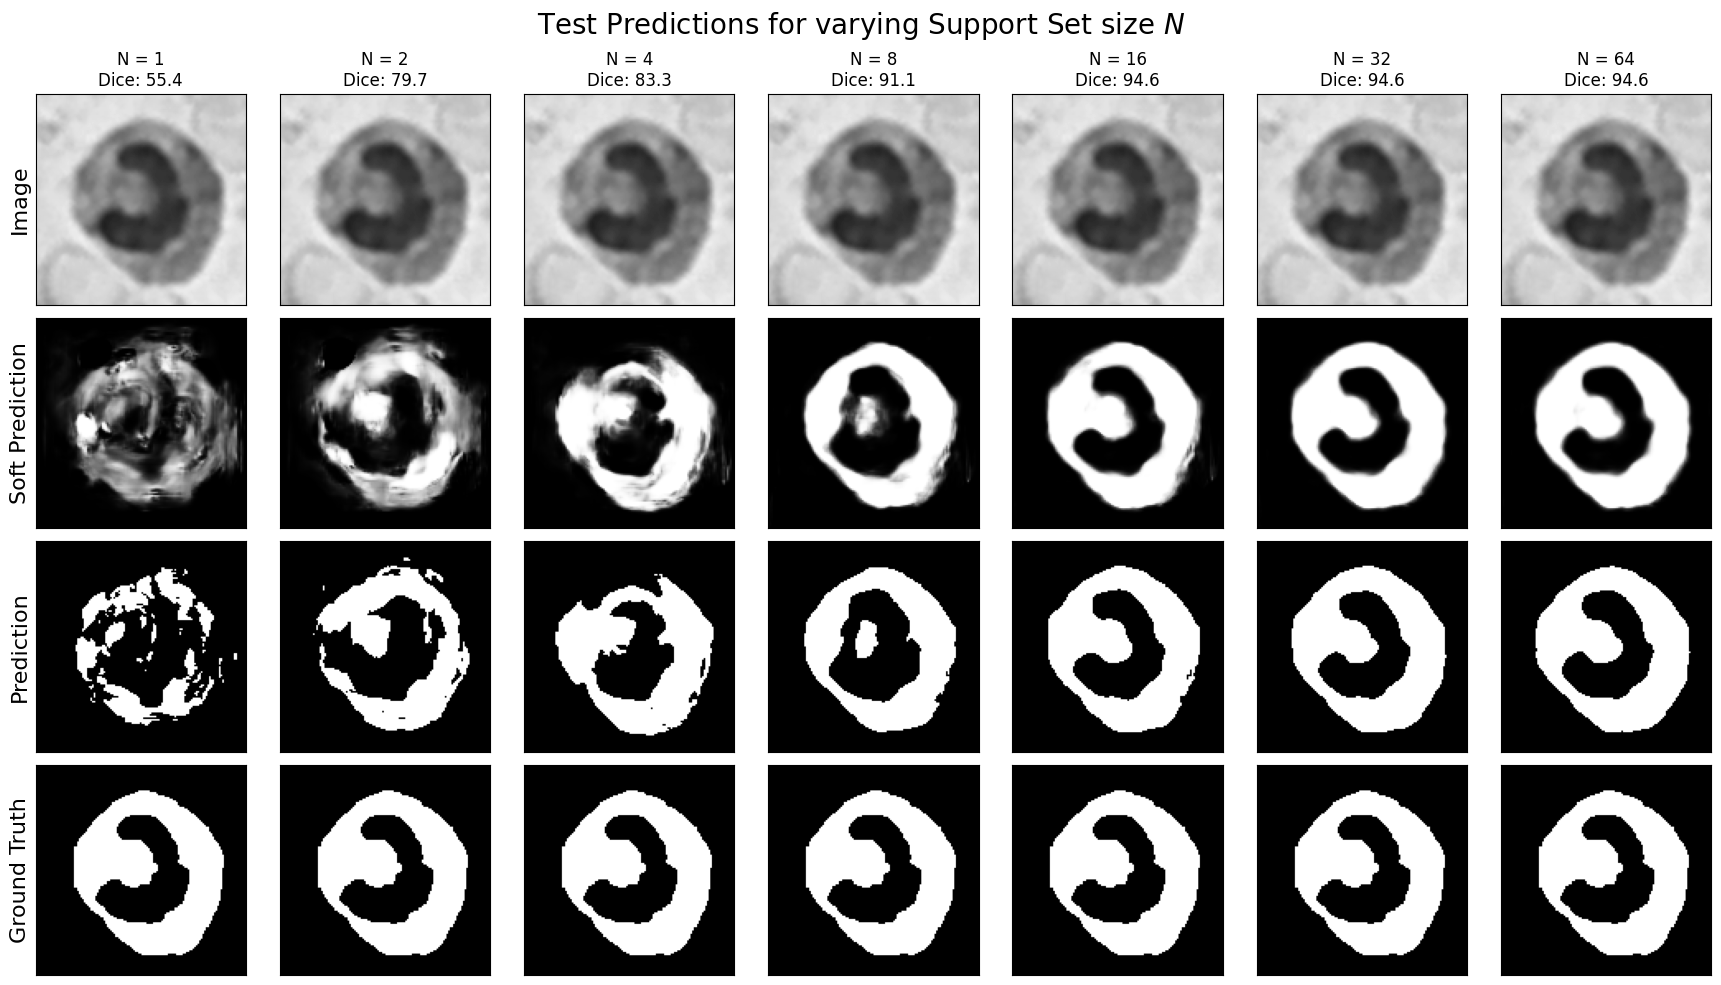

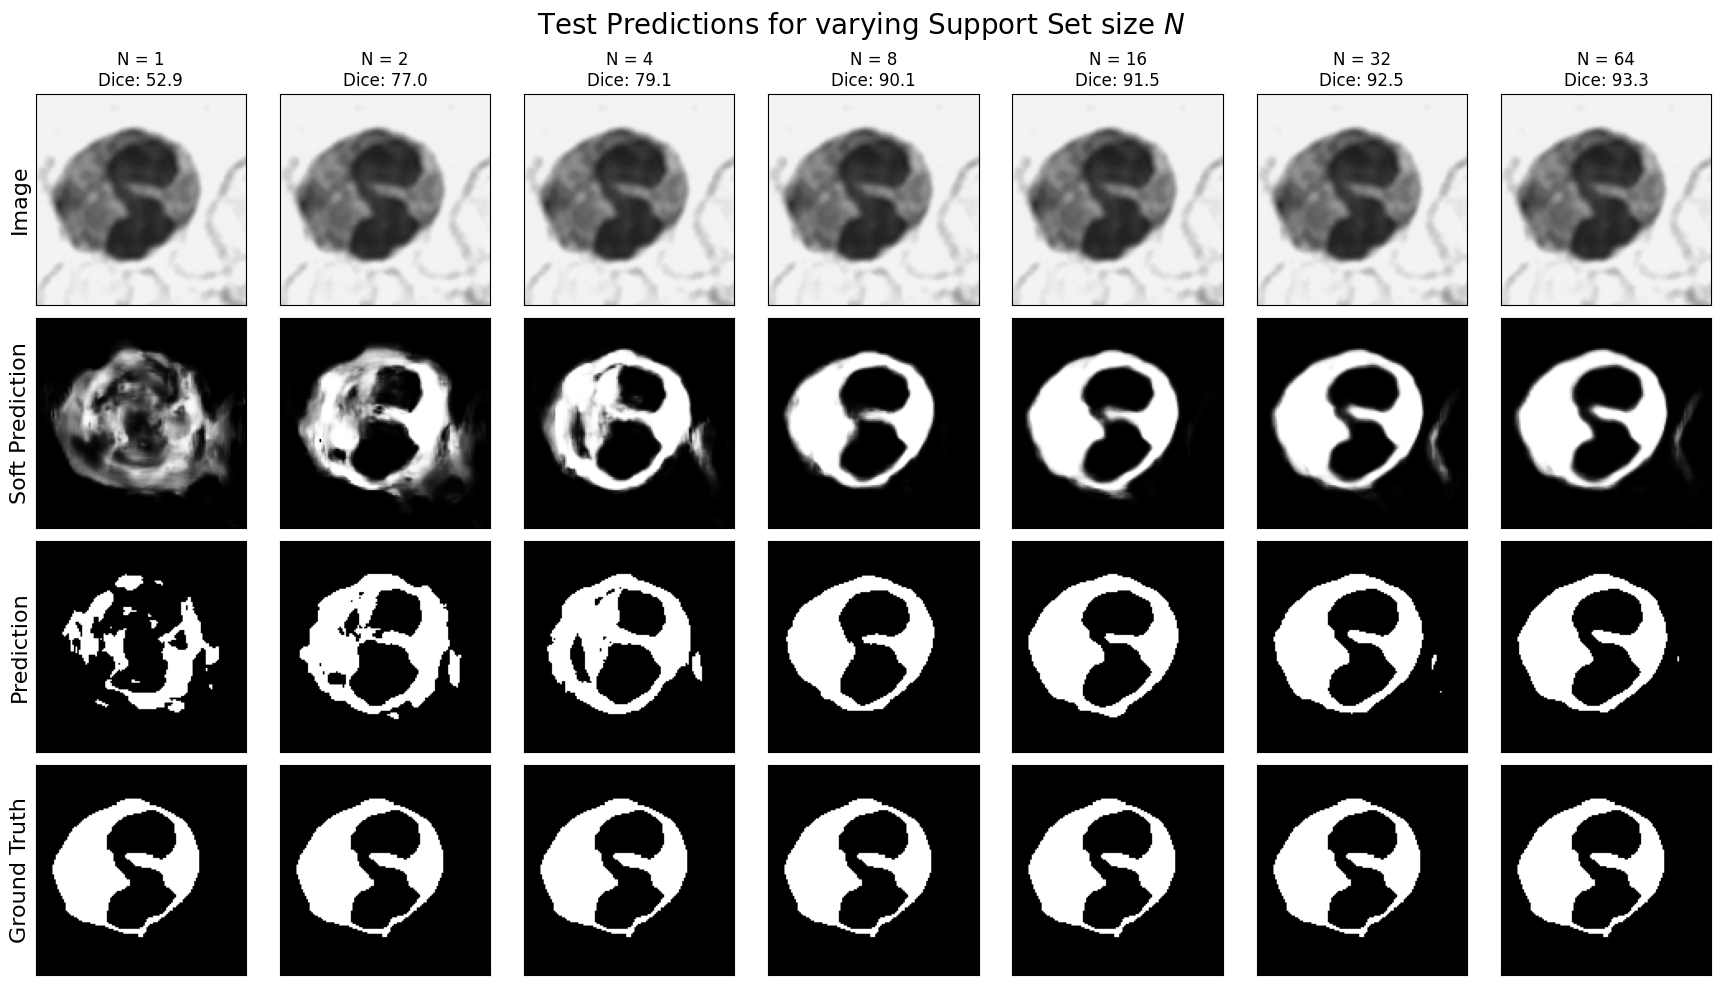

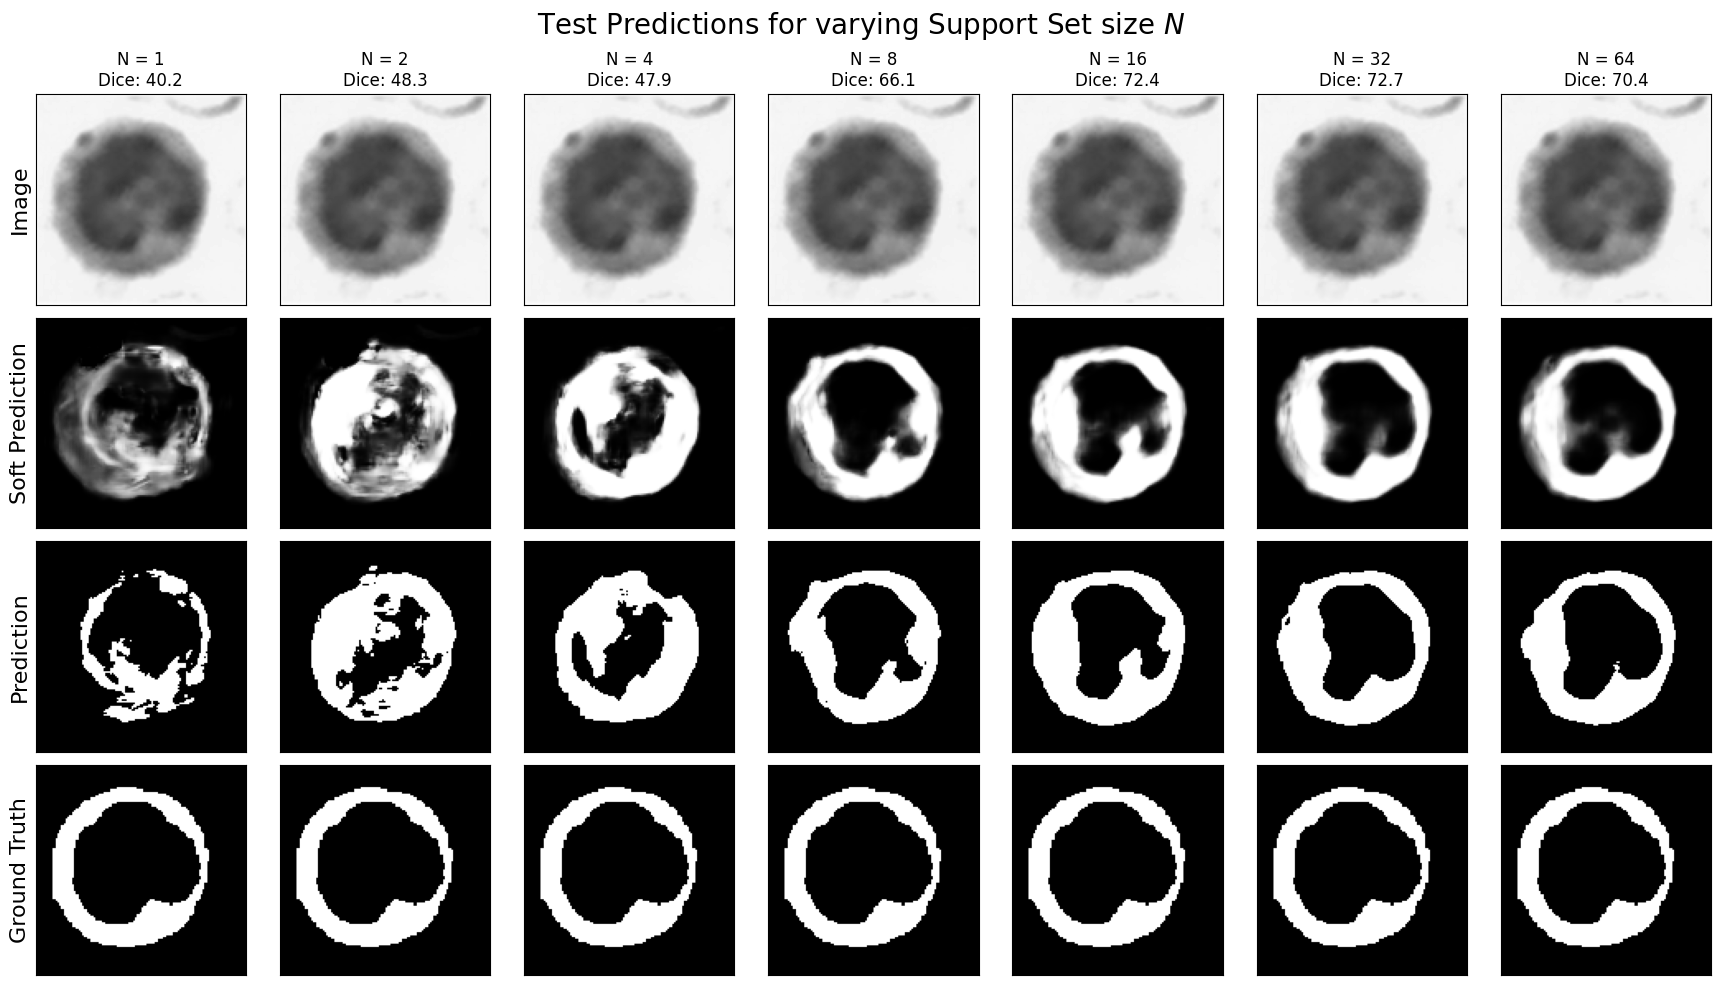

In [ ]:
n_predictions = 3
support_set_sizes = [1, 2, 4, 8, 16, 32, 64]

idxs = np.random.permutation(len(d_test))[:n_predictions]

for i in idxs:
    results = defaultdict(list)
    for N in support_set_sizes:
        image, label = d_test[i]
        vals = inference(model, image, label, support_images[:N], support_labels[:N])
        for k, v in vals.items():
            results[k].append(v)

    # visualize for this entry for different support sizes
    scores = results.pop('score')
    col_names = [f'N = {N}' for N in support_set_sizes]
    col_names = [col+f'\nDice: {100*score:.1f}' for col, score in zip(col_names, scores)]
    visualize_tensors(results, col_names=col_names, title='Test Predictions for varying Support Set size $N$', col_wrap=len(support_set_sizes))

We can see that increasing the support improves the accuracy of the prediction, with quite good predictions for N=4 or N=8 already, showing that for some datasets UniverSeg can get great results even in the low data regime.

However, UniverSeg can take advantage of larger datasets and continue to improve. We analyze this in substantial detail in the [paper](https://arxiv.org/abs/2304.06131).

---

## 6. Multi-label Predictions

The UniverSeg employs a binary segmentation architecture, but can perform multilabel segmentation by running the model with support sets of each label independently and then consolidating the results. Here, we demonstrate how to make such predictions and analyze them.

In [ ]:
d_support = WBCDataset('JTSC', split='support', label=None)
d_test = WBCDataset('JTSC', split='test', label=None)

n_support = 64

support_images, support_labels = zip(*itertools.islice(d_support, n_support))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)

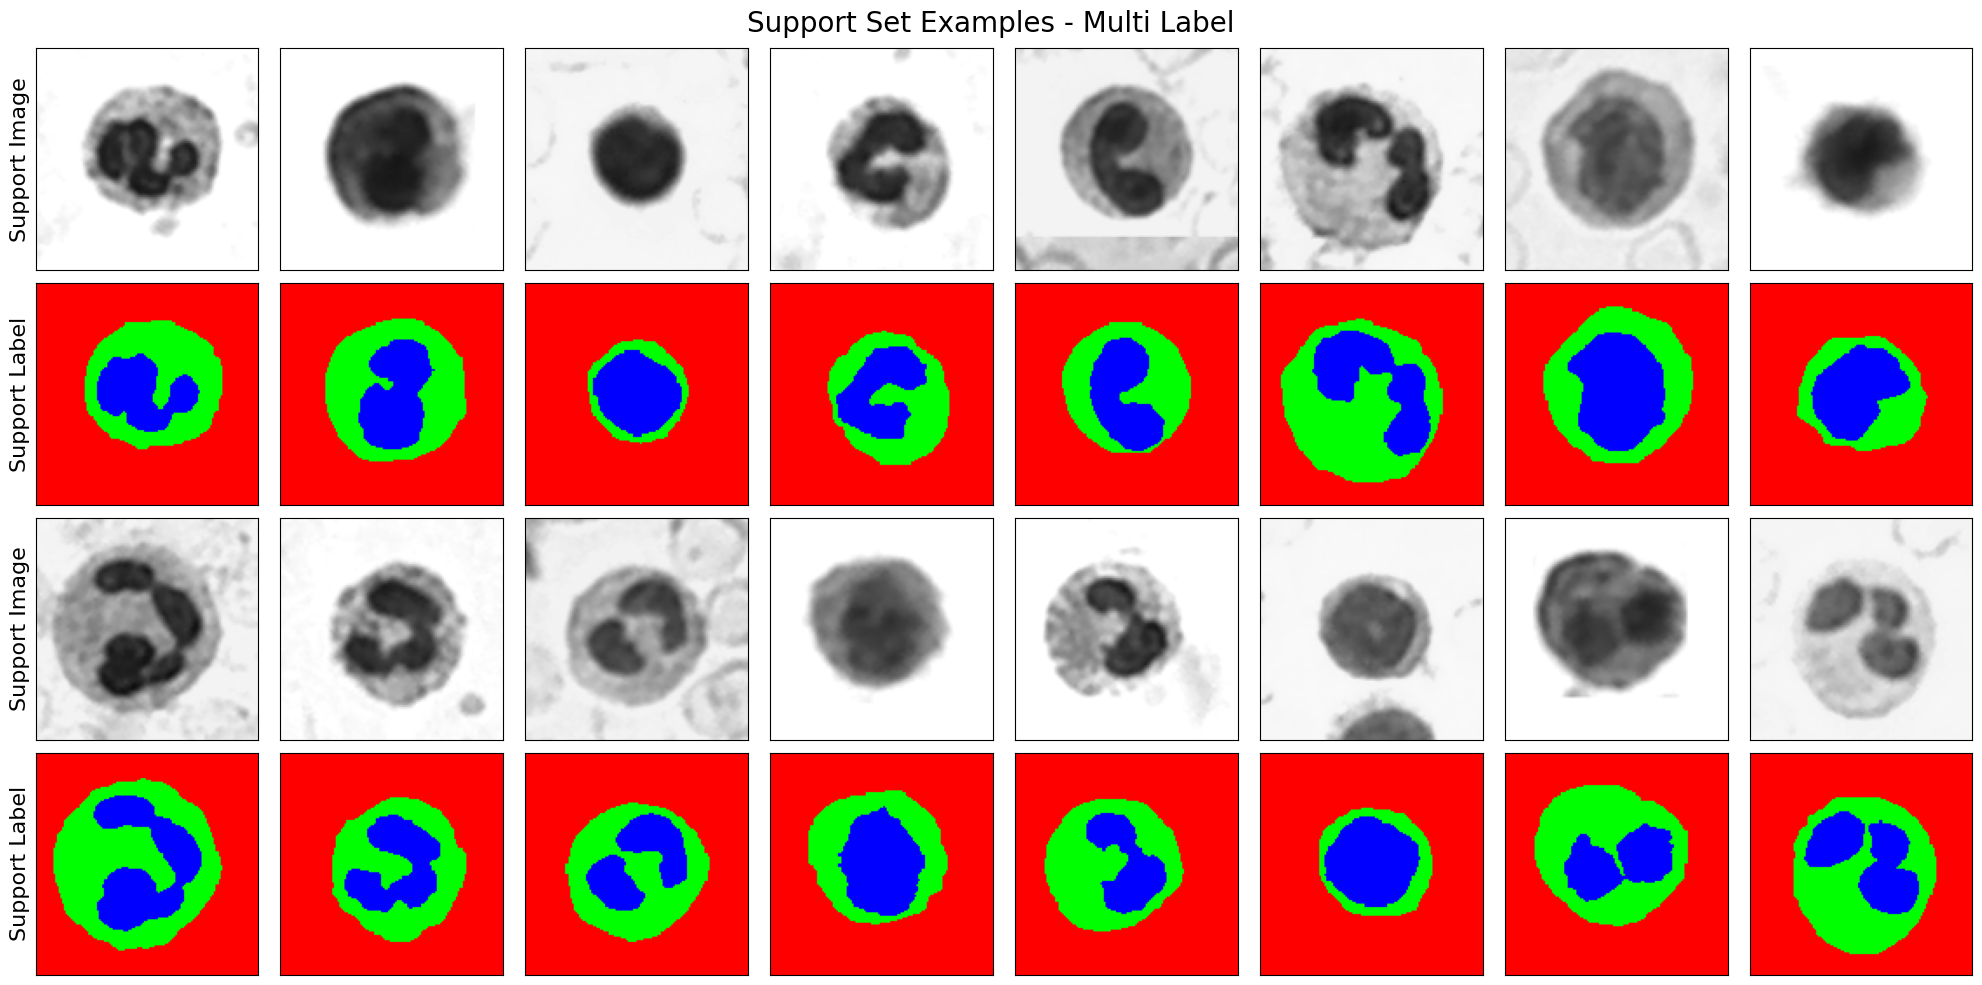

In [ ]:
n_viz = 16
visualize_tensors({
    'Support Image': support_images[:n_viz],
    'Support Label': support_labels[:n_viz],
}, 8, title='Support Set Examples - Multi Label')

We'll setup a multi-label inference-and-score function

In [ ]:
# prepare a function that will perform inference on all available labels
import torch.nn.functional as F

@torch.no_grad()
def inference_multi(model, image, label_onehot, support_images, support_labels_onehot):
    # get data
    n_labels = label_onehot.shape[0]
    image, label_onehot = image.to(device), label_onehot.to(device)

    # go through label
    all_logits = []
    soft_pred_onehot = []
    for k in range(n_labels):
        # extract the right label
        label = label_onehot[k:k+1]
        support_labels = support_labels_onehot[:,k:k+1]

        # run inference on this label
        logits = model(
            image[None],
            support_images[None],
            support_labels[None]
        )[0] # outputs are logits
        soft_pred = torch.sigmoid(logits)
        soft_pred_onehot.append(soft_pred)

    # get multi-label score
    soft_pred_onehot = torch.stack(soft_pred_onehot)
    hard_pred = F.softmax(10*soft_pred_onehot,dim=0)
    scores = []
    for k in range(n_labels):
        score = dice_score(hard_pred[k], label_onehot[k])
        scores.append(score)

    # return the predictions and labels
    return {'Image': image,
            'Soft Prediction': soft_pred_onehot,
            'Prediction': hard_pred,
            'Ground Truth': label_onehot,
            'score': np.mean(scores)}

Let's get 10 multi-label predictions

  0%|          | 0/10 [00:00<?, ?it/s]

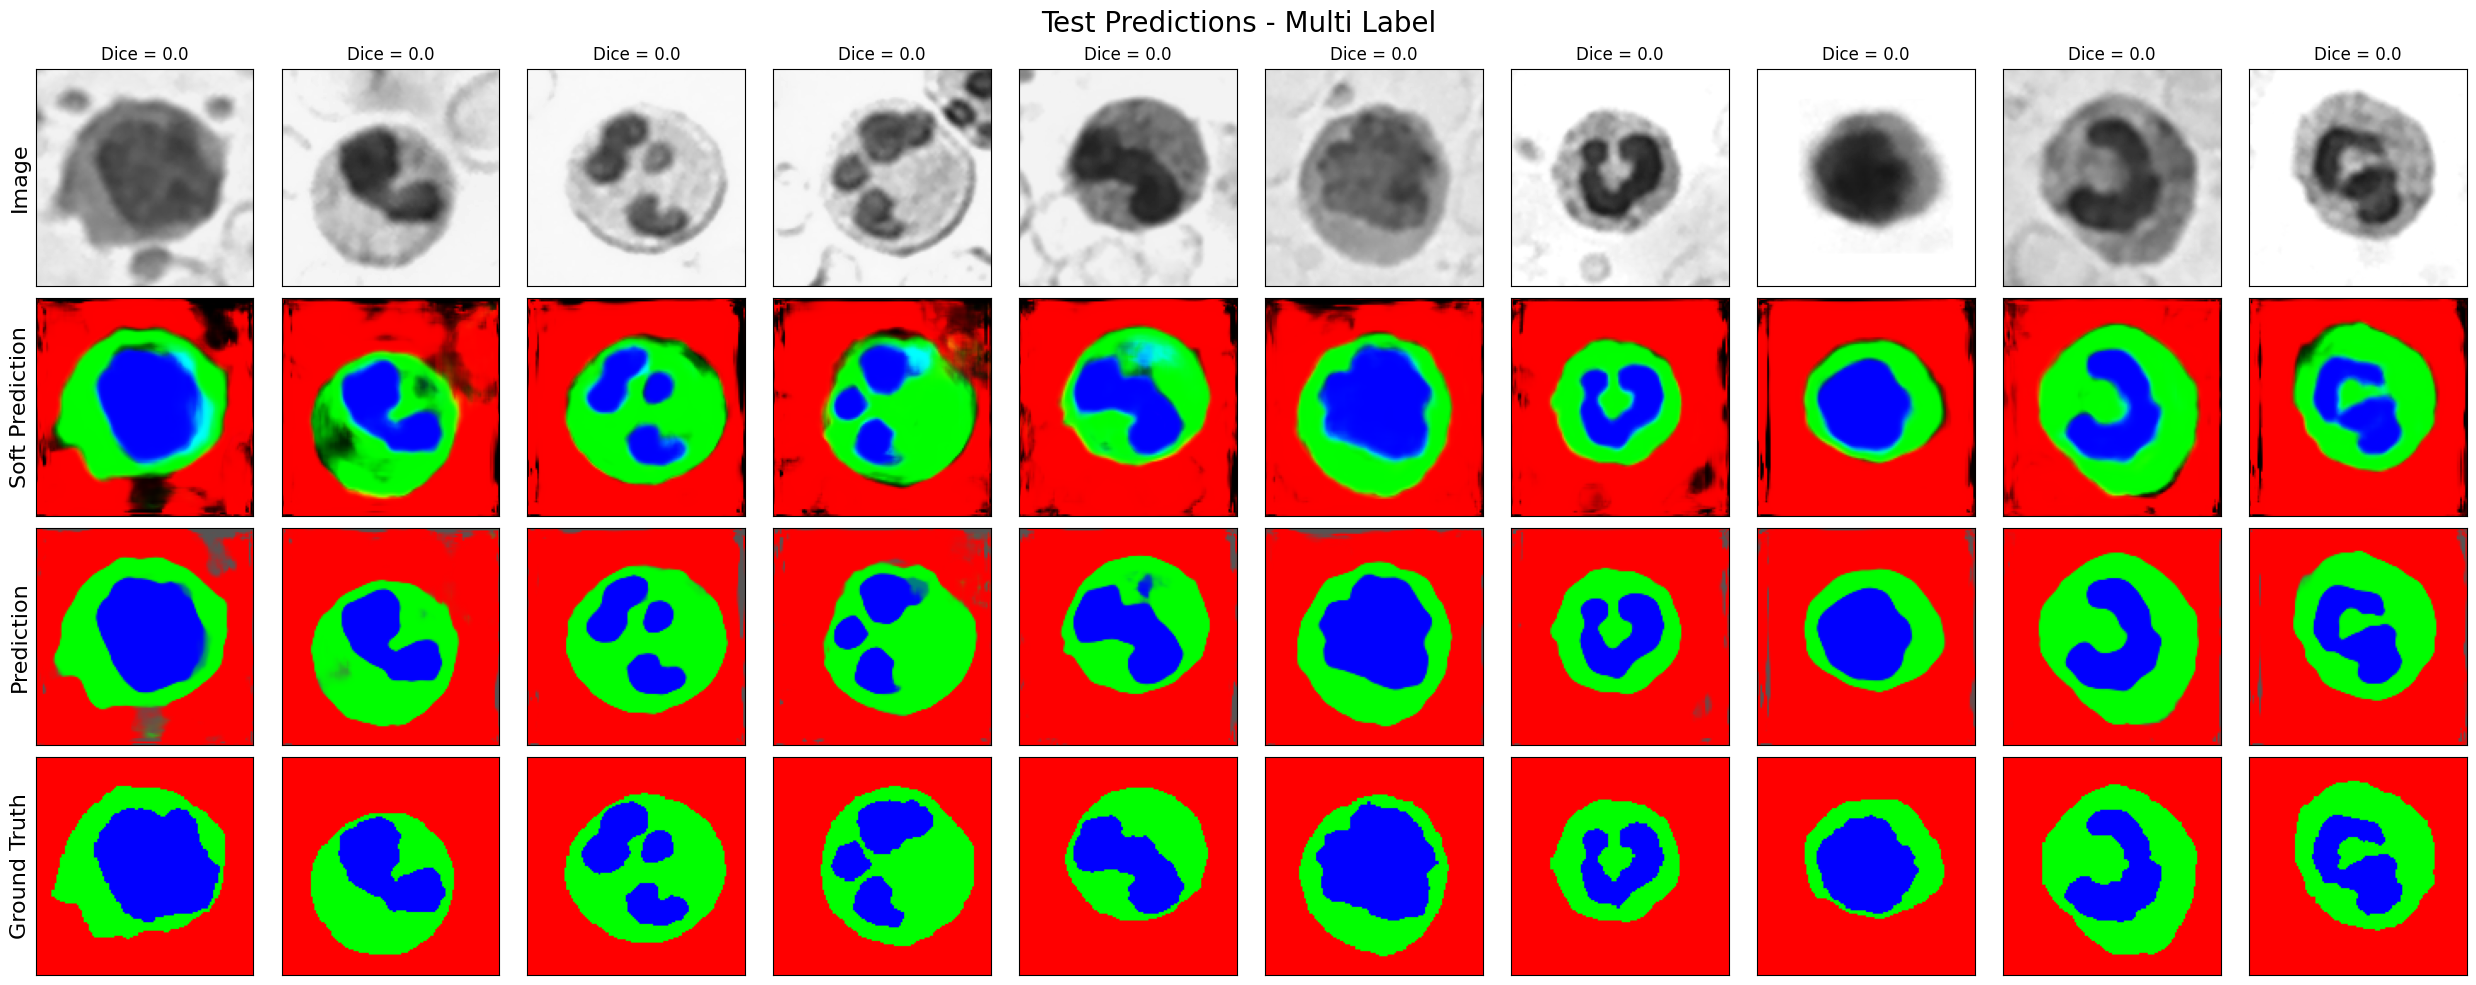

In [ ]:
n_predictions = 10

results = defaultdict(list)
idxs = np.random.permutation(len(d_test))[:n_predictions]

for i in tqdm(idxs):
    image, label = d_test[i]
    vals = inference_multi(model, image, label, support_images, support_labels)
    for k, v in vals.items():
        results[k].append(v)

scores = results.pop('score')
visualize_tensors(results, col_names=[f'Dice = {100*s:.1f}' for s in scores], title='Test Predictions - Multi Label', col_wrap=n_predictions)

___


## 7. Ensembling Predictions

Different support sets lead to different prediction segmentations.  
In this section we show that ensembling predictions can lead to improved results, especially for smaller support sets used in each prediction.  
We analyze this in more detail in the [paper](https://arxiv.org/abs/2304.06131).

In [ ]:
# helpful function to sample support data
def sample_support(seed):
    rng = np.random.default_rng(seed)
    idxs = rng.integers(0,len(d_support), size=support_size)
    support_images, support_labels = zip(*[d_support[i] for i in idxs])
    support_images = torch.stack(support_images).to(device)
    support_labels = torch.stack(support_labels).to(device)
    return support_images, support_labels

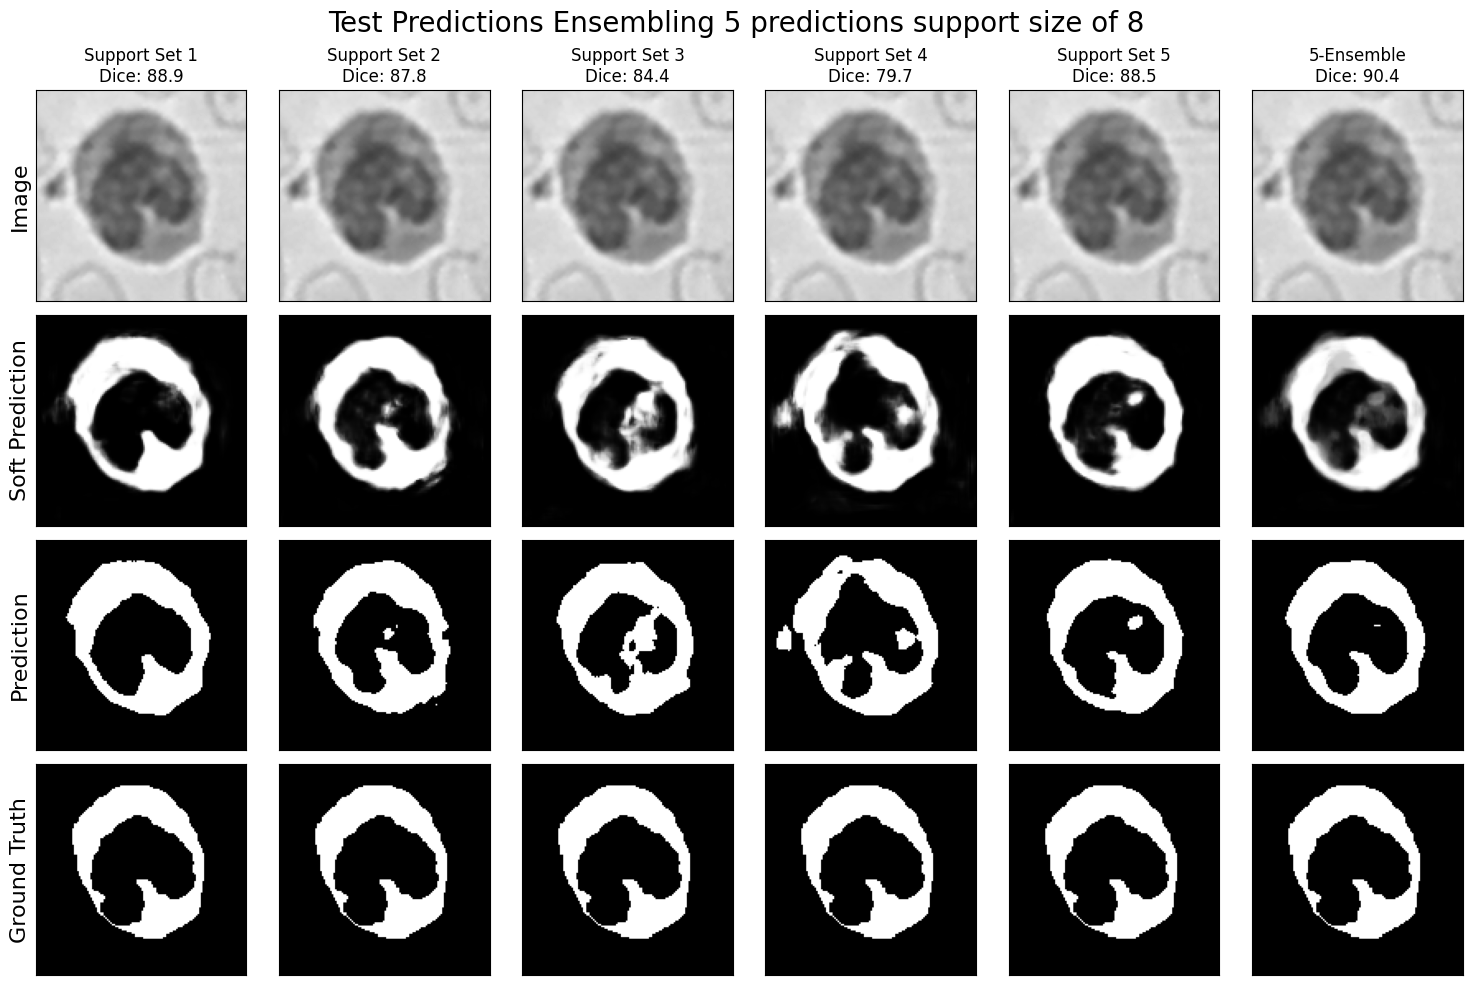

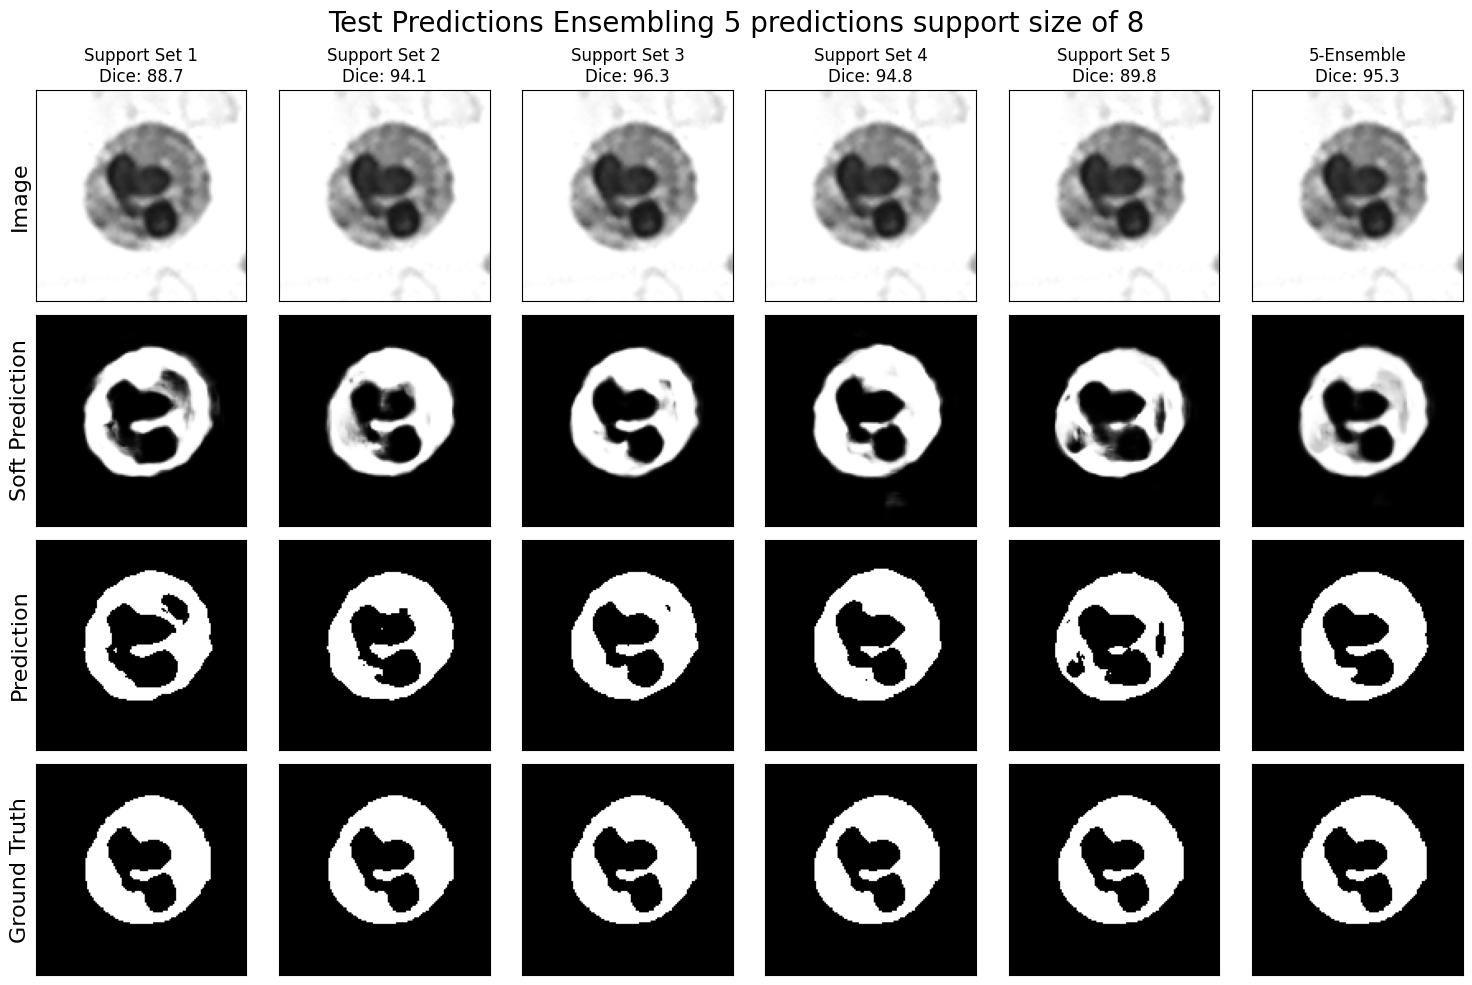

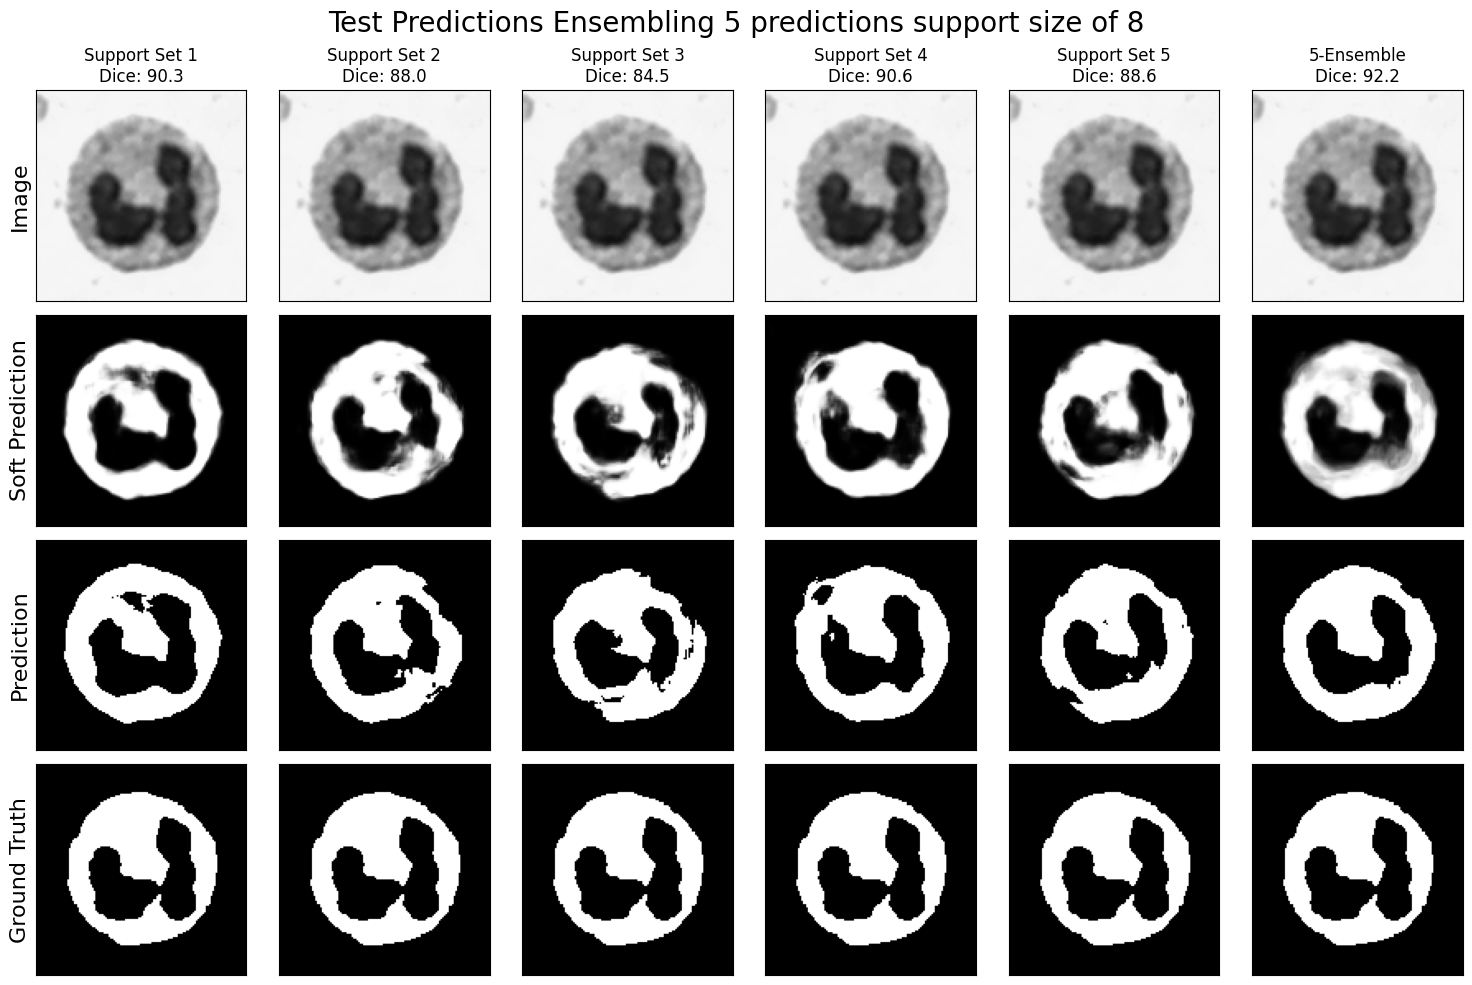

In [ ]:
# get support data
d_support = WBCDataset('JTSC', split='support', label='cytoplasm')
d_test = WBCDataset('JTSC', split='test', label='cytoplasm')

# setup the number of predictions and ensembling
support_size = 8
n_predictions = 3
n_ensemble = 5

# get various support sets
idxs = np.random.permutation(len(d_test))[:n_predictions]
seeds = range(n_ensemble)
supports = {
    seed: sample_support(seed)
    for seed in range(n_ensemble)
}

# go through the number of experiments
for i in idxs:

    # go through the number of predictions we will ensemble
    results = defaultdict(list)
    for j in range(n_ensemble):
        # get support set and query
        support_images, support_labels = sample_support(j)
        image, label = d_test[i]

        # perform inference
        vals = inference(model, image, label, support_images, support_labels)
        for k, v in vals.items():
            results[k].append(v)

    results['Image'].append(image)
    ensemble = torch.mean(torch.stack(results['Soft Prediction']), dim=0)
    results['Soft Prediction'].append(ensemble)
    results['Prediction'].append(ensemble.round())
    results['Ground Truth'].append(label)
    results['score'].append(dice_score(ensemble.round(), label.to(device)))

    scores = results.pop('score')
    col_names = [f'Support Set {i+1}' for i in range(n_ensemble)] + [f'{n_ensemble}-Ensemble']
    col_names = [col+f'\nDice: {100*score:.1f}' for col, score in zip(col_names, scores)]

    visualize_tensors(results,
                      col_names=col_names,
                      title=f'Test Predictions Ensembling {n_ensemble} predictions support size of {support_size}',
                      col_wrap=n_ensemble+1)

In general, we find that (for small support sets) each prediction can be reasonable with small errors, but importantly the ensemble process fixes most problems!

# 8. Test inference on OASIS brain dataset

We will now test a mid-coronal brain slice as part of the OASIS dataset prepared for the HyperMorph project.  
Dataset and details here: https://github.com/adalca/medical-datasets/blob/master/neurite-oasis.md

In [ ]:
import example_data.oasis
d_support = example_data.oasis.OASISDataset('support', label=1)
d_test = example_data.oasis.OASISDataset('test', label=1)

support_images, support_labels = zip(*itertools.islice(d_support, 10))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)

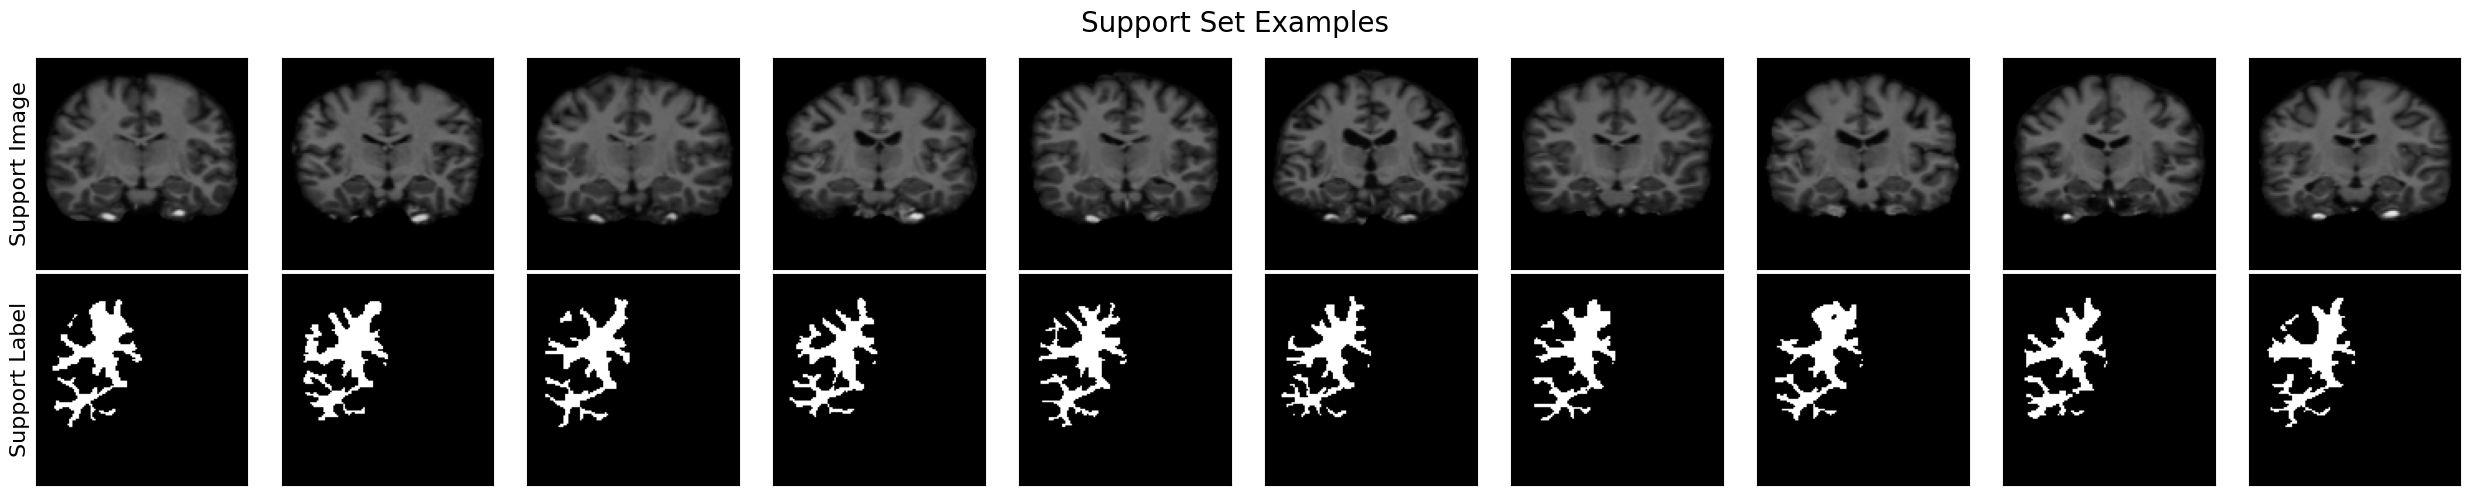

In [ ]:
n_viz = 10
visualize_tensors({
    'Support Image': support_images[:n_viz],
    'Support Label': support_labels[:n_viz],
}, col_wrap=10, title='Support Set Examples')

Let's perform inference on a test entry and visualize the prediction

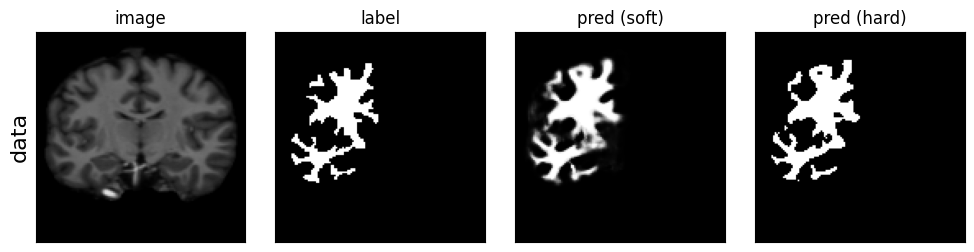

In [ ]:
# select an image, label test pair
idx = np.random.permutation(len(d_test))[0]
image, label = d_test[idx]
image, label = image.to(device), label.to(device)

# run inference
logits = model(image[None], support_images[None], support_labels[None])[0].to('cpu')
pred = torch.sigmoid(logits)

# visualize
res = {'data': [image, label, pred, pred > 0.5]}
titles = col_names=['image', 'label', 'pred (soft)', 'pred (hard)']
visualize_tensors(res, col_wrap=4, col_names=titles)